## kaggle:https://www.kaggle.com/code/czy111/vae-mnist-and-celeba

## VAE MNIST(pytorch)

In [49]:
# VAE.py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

class Reshape(nn.Module):
    def __init__(self, args):
        super(Reshape, self).__init__()
        self.shape = args
    def forward(self, x):
        return x.view(self.shape)
# 定义 VAE 编码器
class VAEEncoder(nn.Module):
    def __init__(self, hidden_size, latent_size):
        super().__init__()
        self.conv1=nn.Conv2d(1,16,kernel_size=3,stride=2,padding=1)
        self.conv2=nn.Conv2d(16,32,kernel_size=3,stride=2,padding=1)
        self.conv3=nn.Conv2d(32,64,kernel_size=7)
        self.flatten= nn.Flatten()
            #nn.Linear(in_features=64,out_features=2),
        self.fc1 = nn.Linear(64, hidden_size)
        self.fc2 = nn.Linear(hidden_size, latent_size * 2)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x=torch.relu(self.conv2(x))
        x=torch.relu(self.conv3(x))
        x=self.flatten(x)
        #print(x.shape)
        #print(self.fc1)
        x=torch.relu(self.fc1(x))
        x = self.fc2(x)
        mu, log_var = x.split(latent_size, dim=1)
        return mu, log_var

# 定义 VAE 解码器
class VAEDecoder(nn.Module):
    def __init__(self, latent_size, hidden_size):
        super().__init__()
        self.fc1 = nn.Linear(latent_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 64)
        self.reshape=Reshape((-1, 64, 1, 1))
        self.convTran1=nn.ConvTranspose2d(64,32,kernel_size=7)
        self.convTran2=nn.ConvTranspose2d(32,16,kernel_size=3,stride=2,padding=1,output_padding=1)
        self.convTran3=nn.ConvTranspose2d(16,1,kernel_size=3,stride=2,padding=1,output_padding=1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x=self.reshape(x)
        x=torch.relu(self.convTran1(x))
        x=torch.relu(self.convTran2(x))
        x=torch.sigmoid(self.convTran3(x))
        return x

# 定义 VAE 模型
class VAE(nn.Module):
    def __init__(self,hidden_size, latent_size):
        super().__init__()
        self.encoder = VAEEncoder(hidden_size, latent_size)
        self.decoder = VAEDecoder(latent_size, hidden_size)

    def forward(self, x):
        mu, log_var = self.encoder(x)
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mu + std * eps
        recon = self.decoder(z)
        return recon, mu, log_var

# 定义 VAE 损失函数
def vae_loss(recon, x, mu, log_var):
    #print(recon,x)
    recon_loss = nn.BCELoss(reduction='sum')(recon, x)
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return recon_loss + kl_loss

# 加载 MNIST 数据集
transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.5,), (0.5,))
])
mnist = datasets.MNIST(root='.', download=True, transform=transform)

# 定义训练参数
batch_size = 64
lr = 1e-3
num_epochs = 10

# 定义数据加载器
data_loader = DataLoader(mnist, batch_size=batch_size, shuffle=True) # shuffle=True 打乱数据

# 定义模型、优化器和损失函数
# 定义 VAE 模型
input_size = 28 * 28
hidden_size = 256
latent_size = 64




In [53]:
import tqdm
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = VAE( hidden_size, latent_size)
model=model.to(device)
# 定义优化器
optimizer = optim.Adam(model.parameters(), lr=lr)


# 训练 VAE 模型
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for x, _ in tqdm.tqdm(data_loader):
       # x = x.view(-1, input_size)
        #print(x)
        x=x.to(device)
        recon, mu, log_var = model(x)
        loss = vae_loss(recon, x, mu, log_var)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f'Epoch {epoch+1} loss: {epoch_loss / len(mnist):.4f}')              
    
# 保存模型
torch.save(model.state_dict(), 'vae.pth')

  1%|          | 6/938 [00:00<00:17, 53.18it/s]

Epoch 1 loss: 201.6888


  1%|          | 6/938 [00:00<00:17, 51.79it/s]

Epoch 2 loss: 161.5033


  1%|          | 6/938 [00:00<00:17, 52.59it/s]

Epoch 3 loss: 144.7313


  1%|          | 5/938 [00:00<00:18, 49.36it/s]

Epoch 4 loss: 137.6083


  1%|          | 6/938 [00:00<00:17, 51.92it/s]

Epoch 5 loss: 132.8083


  1%|          | 6/938 [00:00<00:17, 54.59it/s]

Epoch 6 loss: 129.5547


  1%|          | 6/938 [00:00<00:17, 53.37it/s]

Epoch 7 loss: 126.7451


  1%|          | 6/938 [00:00<00:17, 54.06it/s]

Epoch 8 loss: 124.1758


  1%|          | 6/938 [00:00<00:17, 53.80it/s]

Epoch 9 loss: 121.2565


100%|██████████| 938/938 [00:17<00:00, 54.25it/s]

Epoch 10 loss: 119.3369


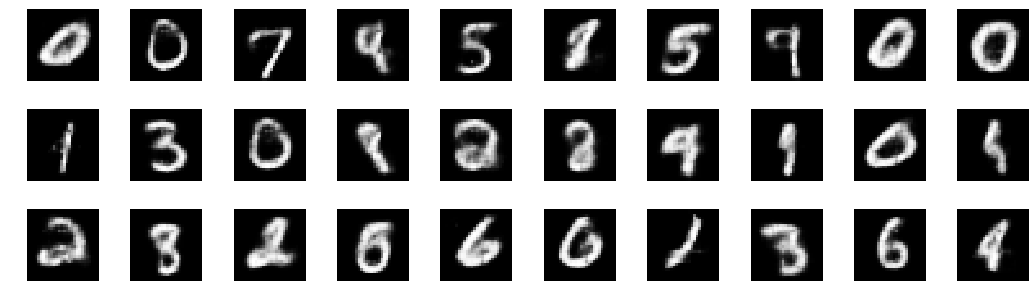

In [110]:
n_to_show = 30

znew =torch.from_numpy( np.random.normal(size = (n_to_show,latent_size)))
model.eval()
recon = model.decoder(znew.float().cuda())

fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(n_to_show):
    img = recon[i].squeeze()
    ax = fig.add_subplot(3, 10, i+1)
    ax.imshow(img.detach().cpu().numpy(),cmap='gray')
    ax.axis('off')

plt.show()
fig.savefig('1.png')

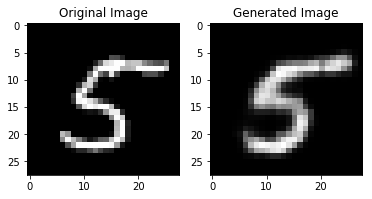

In [94]:
# generate.py 
import torch
import matplotlib.pyplot as plt
from torch.utils.data import WeightedRandomSampler,DataLoader
#from VAE import model, input_size, mnist # 从 VAE.py 中导入模型、输入大小和 MNIST 数据集

# 加载已训练好的模型
model.load_state_dict(torch.load('vae.pth'))

dataloader = DataLoader(dataset=mnist,
                    batch_size=64,  # 组织成batch大小
                    sampler=WeightedRandomSampler(torch.ones(len(mnist)), 64))

example_batch,label=next(iter(dataloader))
sample_images = example_batch.to(device)

recon,mu, log_var = model(sample_images)


# 显示原始图像和生成的图像
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(sample_images.squeeze()[0].detach().cpu().numpy(), cmap='gray')
plt.subplot(1, 2, 2)
plt.title('Generated Image')
plt.imshow(recon.squeeze()[0].detach().cpu().numpy(), cmap='gray')
plt.show()


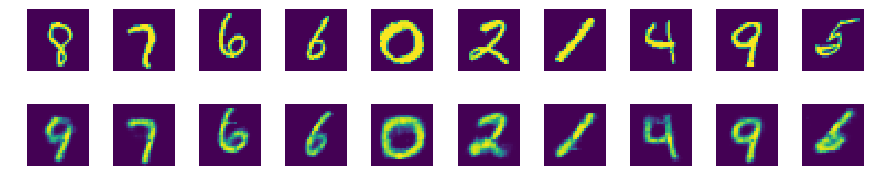

In [100]:
n_to_show = 10

dataloader = DataLoader(dataset=mnist,
                    batch_size=64,  # 组织成batch大小
                    sampler=WeightedRandomSampler(torch.ones(len(mnist)), 64))

example_batch,label=next(iter(dataloader))
sample_images = example_batch.to(device)

recon,mu, log_var = model(sample_images)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = sample_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+1)
    sub.axis('off')        
    sub.imshow(img.detach().cpu().numpy())

for i in range(n_to_show):
    img = recon[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    sub.axis('off')
    sub.imshow(img.detach().cpu().numpy())
fig.savefig('2.png')







## VAE fashion-mnist(tensorflow)

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics,
)

from scipy.stats import norm

IMAGE_SIZE = 32
BATCH_SIZE = 100
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 5
BETA = 500

# Load the data
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

# Preprocess the data


def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)

2024-03-17 03:06:23.573811: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-17 03:06:23.573929: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-17 03:06:23.755547: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [3]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Encoder
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, 1), name="encoder_input"
)
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
    encoder_input
)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

x = layers.Flatten()(x)
z_mean = layers.Dense(EMBEDDING_DIM, name="z_mean")(x)
z_log_var = layers.Dense(EMBEDDING_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

# Decoder
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(x)
decoder_output = layers.Conv2D(
    1,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(
                BETA
                * losses.binary_crossentropy(
                    data, reconstruction, axis=(1, 2, 3)
                )
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA
            * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │        320 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 8, 8, 64)  │     18,496 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 4, 4, 128) │     73,856 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 2048)      │          0 │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │      4,098 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │      4,098 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_1          │ (None, 2)         │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 100,868 (394.02 KB)

 Trainable params: 100,868 (394.02 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2048)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Conv2D)         │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
!git clone https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Cloning into 'Generative_Deep_Learning_2nd_Edition'...
remote: Enumerating objects: 653, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 653 (delta 35), reused 37 (delta 26), pack-reused 564
Receiving objects: 100% (653/653), 37.12 MiB | 15.61 MiB/s, done.
Resolving deltas: 100% (364/364), done.


In [5]:
cd /kaggle/working/Generative_Deep_Learning_2nd_Edition/notebooks/03_vae

/kaggle/working/Generative_Deep_Learning_2nd_Edition/notebooks/03_vae


In [7]:
# Create a variational autoencoder
vae = VAE(encoder, decoder)

# Compile the variational autoencoder
optimizer = optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer)

# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint.keras",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

In [8]:
vae.fit(
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=[model_checkpoint_callback, tensorboard_callback],
)

Epoch 1/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 101s 163ms/step - kl_loss: 3.7561 - reconstruction_loss: 195.5300 - total_loss: 199.2861 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 2/5


/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


600/600 ━━━━━━━━━━━━━━━━━━━━ 141s 162ms/step - kl_loss: 4.7959 - reconstruction_loss: 133.3156 - total_loss: 138.1115 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 3/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 143s 164ms/step - kl_loss: 4.9005 - reconstruction_loss: 130.7375 - total_loss: 135.6380 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 4/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 141s 163ms/step - kl_loss: 5.0268 - reconstruction_loss: 129.1948 - total_loss: 134.2215 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 5/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 142s 163ms/step - kl_loss: 5.0870 - reconstruction_loss: 128.3503 - total_loss: 133.4373 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00


In [11]:
import matplotlib.pyplot as plt


def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()


def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()


157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step
Example real clothing items


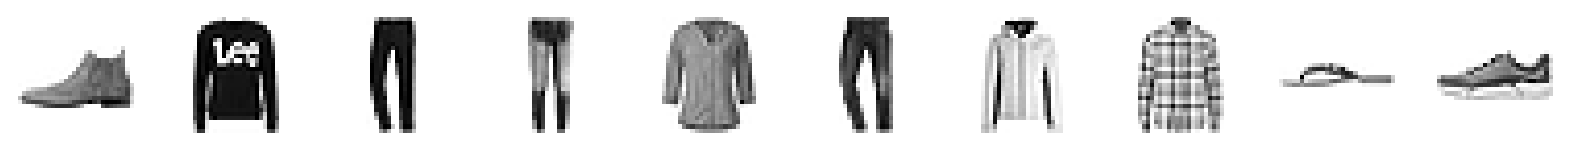

Reconstructions


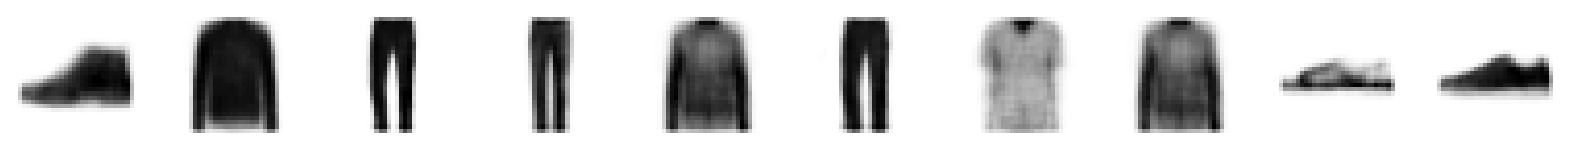

In [12]:
# Select a subset of the test set
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

# Create autoencoder predictions and display
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("Example real clothing items")
display(example_images)
print("Reconstructions")
display(reconstructions)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
[[-1.3402616   0.77968943]
 [-0.10718055 -1.4137713 ]
 [ 2.730896   -1.0913444 ]
 [ 1.9796718   0.781301  ]
 [-0.06885841 -0.13891512]
 [ 1.8362694  -1.3440714 ]
 [ 0.52328396  0.6973826 ]
 [ 0.22364765  0.15797608]
 [ 0.44942617  2.6530247 ]
 [-0.49608257  2.3000689 ]]


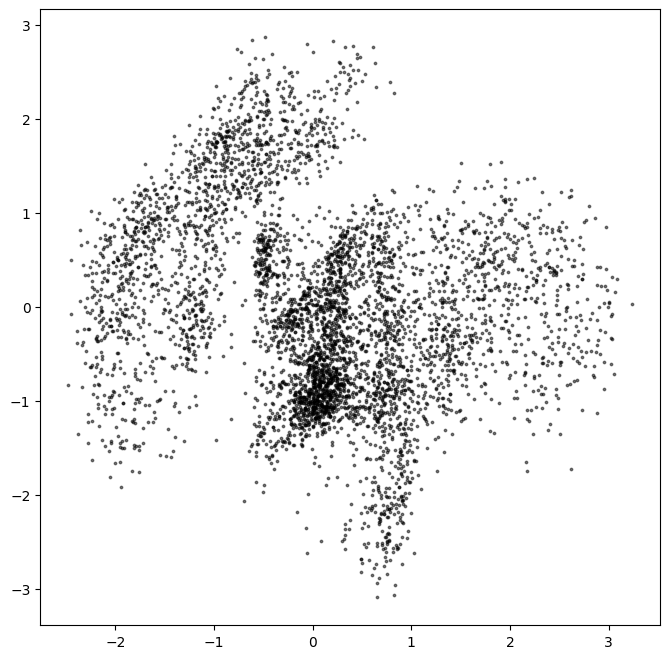

In [13]:
# Encode the example images
z_mean, z_var, z = encoder.predict(example_images)
# Some examples of the embeddings
print(z[:10])
# Show the encoded points in 2D space
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=3)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


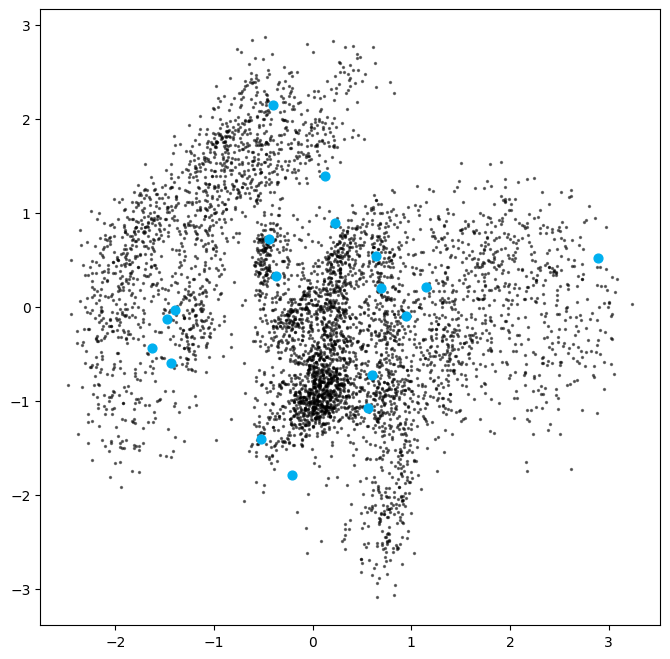

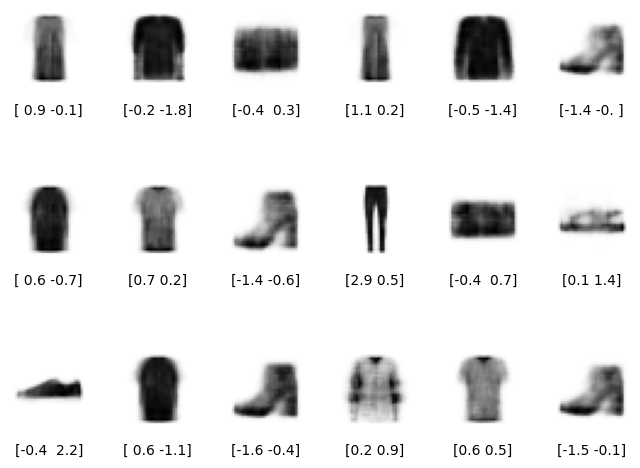

In [14]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (6, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, 2))

# Decode the sampled points
reconstructions = decoder.predict(z_sample)

# Convert original embeddings and sampled embeddings to p-values
p = norm.cdf(z)
p_sample = norm.cdf(z_sample)

# Draw a plot of...
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(z_sample[:, 0], z_sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(z_sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

## celeba数据集上训练VAE（pytorch）

In [1]:
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import models,transforms

import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models,transforms

torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

#finished()


In [2]:
def make_datapath_list(root_path):
    """
    Returns:
    -----------
    path_list:list
    保存数据路径的列表
    """
    #root_path='/kaggle/input/celebrity-face-image-dataset/Celebrity Faces Dataset'
    target_path=osp.join(root_path+'/**/*.jpg')
    #print(target_path)
    
    path_list=[]
    
    #使用glob取得文件路径
    return glob.glob(target_path)

root_path='/kaggle/input/celeba'
l=make_datapath_list(root_path)

train_num=int(len(l)*0.8)
train_list=l[:train_num]
test_list=l[train_num:]
len(test_list)

40520

In [3]:
#创建Dataset
class CelebDataset(data.Dataset):
    """
    file_path:list
    transform:object
    phase:'train' or 'val'
    """
    def __init__(self,file_list,transform=None,phase='train'):
        self.file_list=file_list
        self.transform=transform
        self.phase=phase
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self,index):
        """
        获取预处理完毕的图片的张量数据和标签
        """
        img_path=self.file_list[index]
        img=Image.open(img_path)
        img_tranformed=self.transform(img)
        


        return img_tranformed
    
Input_size=(128,128)
transform=torchvision.transforms.Compose([
    torchvision.transforms.Resize(Input_size),
    torchvision.transforms.ToTensor(),    
])
train_dataset=CelebDataset(file_list=train_list,transform=transform,phase='train')
test_dataset=CelebDataset(file_list=test_list,transform=transform,phase='test')

index=1
print(train_dataset.__getitem__(index))
print(train_dataset.__getitem__(index)[0].size())


tensor([[[1.0000, 1.0000, 1.0000,  ..., 0.9961, 0.9961, 0.9961],
         [1.0000, 1.0000, 1.0000,  ..., 0.9961, 0.9961, 0.9961],
         [1.0000, 1.0000, 1.0000,  ..., 0.9961, 0.9961, 0.9961],
         ...,
         [0.7020, 0.6627, 0.6314,  ..., 0.9451, 0.9451, 0.9451],
         [0.7020, 0.6667, 0.6353,  ..., 0.9412, 0.9412, 0.9490],
         [0.6980, 0.6549, 0.6667,  ..., 0.9490, 0.9490, 0.9451]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.5137, 0.4745, 0.4353,  ..., 0.8706, 0.8745, 0.8784],
         [0.5137, 0.4745, 0.4353,  ..., 0.8667, 0.8706, 0.8824],
         [0.5020, 0.4549, 0.4627,  ..., 0.8667, 0.8706, 0.8784]],

        [[1.0000, 1.0000, 1.0000,  ..., 0.9765, 0.9765, 0.9765],
         [1.0000, 1.0000, 1.0000,  ..., 0.9765, 0.9765, 0.9765],
         [1.0000, 1.0000, 1.0000,  ..., 0.9765, 0.9765, 0.

In [16]:
#创建DataLoader
batch_size=32
train_dataloader=torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_dataloader=torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,shuffle=False)
dataloaders_dict={
    'train':train_dataloader,
    'test':test_dataloader
}

batch_iter=iter(dataloaders_dict['train'])#转成迭代器
inputs=next(batch_iter)#取第一个元素
print(inputs.size())


torch.Size([32, 3, 128, 128])


In [5]:
import torch.nn.functional as F
# 定义 VAE 模型
class VAE(nn.Module):
    def __init__(self,z_dim):
        super().__init__()
        self.z_dim=z_dim
        self.encoder_convs=[]
        self.decoder_convs=[]
        self.encoder_out_channels=[32,64,64,64]
        self.decoder_out_channels=[64,64,32]
        self.encoder_convs.append(nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=2,padding=1))
        self.encoder_convs.append(nn.Conv2d(32,64,3,2,1))
        self.encoder_convs.append(nn.Conv2d(64,64,3,2,1))
        self.encoder_convs.append(nn.Conv2d(64,64,3,2,1))
        
            
        self.fc1=nn.Linear(4096,self.z_dim*2)
        self.fc2=nn.Linear(self.z_dim,4096)
        #self.fc2=nn.Linear(4096,self.z_dim)
        self.decoder_convs.append(nn.ConvTranspose2d(64,64,3,2,1,1))
        self.decoder_convs.append(nn.ConvTranspose2d(64,64,3,2,1,1))
        self.decoder_convs.append(nn.ConvTranspose2d(64,32,3,2,1,1))
        self.decoder_convs.append(nn.ConvTranspose2d(32,3,3,2,1,1))
        
        
        self.encoder_batchnorm=[]
        self.decoder_batchnorm=[]
        for out_c in self.encoder_out_channels:
            self.encoder_batchnorm.append(nn.BatchNorm2d(out_c))
        for out_c in self.decoder_out_channels:
             self.decoder_batchnorm.append(nn.BatchNorm2d(out_c))
        self.layers = nn.ModuleList()
        self.layers=nn.ModuleList(self.encoder_convs+self.encoder_batchnorm+
                                  self.decoder_convs+self.decoder_batchnorm) 
        #self.layers.append(self.fc1)
        #self.layers.append(self.fc2)
    def forward(self, x):
        for convs,BN in zip(self.encoder_convs,self.encoder_batchnorm):
            #print(x.device)
            x=convs(x)
            x = BN(x)
            x = F.leaky_relu(x)
            x = nn.Dropout(0.25)(x)
        shape_before_flattening = x.shape
        x=nn.Flatten()(x)
        
        x = self.fc1(x)
        
        mu, log_var = x.split(self.z_dim, dim=1)
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        x = mu + std * eps
        
        x=self.fc2(x)
        x=x.reshape(shape_before_flattening)
        for i in range(len(self.decoder_convs)):
            convs=self.decoder_convs[i]
            x=convs(x)
            if(i<len(self.decoder_convs)-1):
                BN=self.decoder_batchnorm[i]
                x = BN(x)
                x = F.leaky_relu(x)
                x = nn.Dropout(0.25)(x)
            else:
                x=torch.sigmoid(x)
        return x,mu,log_var

model=VAE(200)


In [22]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [95]:

from torchsummary import summary

summary(model, input_size=inputs.size()[1:], batch_size=-1, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
       BatchNorm2d-2           [-1, 32, 64, 64]              64
            Conv2d-3           [-1, 64, 32, 32]          18,496
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 16, 16]          36,928
       BatchNorm2d-6           [-1, 64, 16, 16]             128
            Conv2d-7             [-1, 64, 8, 8]          36,928
       BatchNorm2d-8             [-1, 64, 8, 8]             128
            Linear-9                  [-1, 400]       1,638,800
           Linear-10                 [-1, 4096]         823,296
  ConvTranspose2d-11           [-1, 64, 16, 16]          36,928
      BatchNorm2d-12           [-1, 64, 16, 16]             128
  ConvTranspose2d-13           [-1, 64, 32, 32]          36,928
      BatchNorm2d-14           [-1, 64,

In [ ]:
names=[]
for name,_ in list(model.named_parameters()):
    names.append(name)
names[:5]

In [8]:
        """def vae_r_loss(y_true, y_pred):
            r_loss = K.mean(K.square(y_true - y_pred), axis = [1,2,3])
            return r_loss_factor * r_loss

        def vae_kl_loss(y_true, y_pred):
            kl_loss =  -0.5 * K.sum(1 + self.log_var - K.square(self.mu) - K.exp(self.log_var), axis = 1)
            return kl_loss

        def vae_loss(y_true, y_pred):
            r_loss = vae_r_loss(y_true, y_pred)
            kl_loss = vae_kl_loss(y_true, y_pred)
            return  r_loss + kl_loss"""
R_LOSS_FACTOR = 10000
def rmse_loss(recon,x):
    return torch.mean(torch.pow(recon-x,2),dim=(1,2,3))
def rmse_loss1(recon,x):
    return torch.mean(torch.pow(recon-x,2))
def kl_loss1(mu,log_var):
    return -0.5 * torch.sum(1+log_var-torch.exp(log_var)-mu**2,axis=1)
def kl_loss(mu,log_var):
    return -0.5*torch.sum(1+log_var-torch.pow(mu,2)-torch.exp(log_var),axis=1)
def vae_loss(recon, x, mu, log_var):
    return torch.sum(rmse_loss(recon,x)*R_LOSS_FACTOR+kl_loss(mu,log_var))
criterion=vae_loss
device=torch.device('cpu' if torch.cuda.is_available() else 'cpu')
inputs=inputs.to(device)
model=model.to(device)
x,mu,log_var=model(inputs)
torch.sum(rmse_loss(inputs,x)),kl_loss(mu,log_var),kl_loss1(mu,log_var),rmse_loss1(inputs,x)*32

(tensor(4.0982, grad_fn=<SumBackward0>),
 tensor([30.5531, 19.2943, 62.8671, 19.4854, 77.7409, 29.5348, 20.7505, 35.9768,
         33.1936, 30.3613, 28.3552, 46.5161, 27.2359, 30.8377, 24.3540, 43.7175,
         68.5267, 24.9141, 38.3894, 32.8170, 25.4206, 22.5833, 45.2401, 32.0104,
         41.1185, 34.7510, 24.0703, 22.8682, 18.2113, 30.8180, 38.4967, 36.2246],
        grad_fn=<MulBackward0>),
 tensor([30.5531, 19.2943, 62.8671, 19.4854, 77.7409, 29.5348, 20.7505, 35.9768,
         33.1936, 30.3613, 28.3552, 46.5161, 27.2359, 30.8377, 24.3540, 43.7175,
         68.5267, 24.9141, 38.3894, 32.8170, 25.4206, 22.5833, 45.2401, 32.0104,
         41.1185, 34.7510, 24.0703, 22.8682, 18.2113, 30.8180, 38.4967, 36.2246],
        grad_fn=<MulBackward0>),
 tensor(4.0982, grad_fn=<MulBackward0>))

In [10]:
#模型训练

#torch.backends.cudnn.benchmark=True
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device：',device)
net=VAE(200).to(device)
criterion=vae_loss
optimizer=optim.Adam(params=net.parameters(),lr=0.0005)

num_epochs=5

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1,num_epochs))
    print('-------------------------')

    for phase in ['train','test']:
        if phase=='train':
            net.train()
        else:
            net.eval()

        epoch_loss=0
        epoch_kl=0

        for inputs in tqdm(dataloaders_dict[phase]):
            inputs=inputs.to(device)
            optimizer.zero_grad()
            with torch.set_grad_enabled(phase=='train'):
                #print(inputs.device)
                #inputs.
                recon,mu,log_var=net(inputs)
                #print(recon.device,mu.device,inputs.device)
                
                loss=criterion(recon,inputs, mu, log_var)
                epoch_kl+=torch.sum(kl_loss(mu,log_var))
                #print(loss.item(),kl_loss(mu,log_var).item())
                epoch_loss+=loss
                #print(loss)
                if phase=='train':
                    loss.backward()
                    optimizer.step()

                
        epoch_loss=epoch_loss/len(dataloaders_dict[phase].dataset)
        epoch_kl=epoch_kl/len(dataloaders_dict[phase].dataset)
        print('{} Loss:{:.4f} kl_loss:{:.4f} '.format(phase,epoch_loss,epoch_kl))



device： cuda:0


  0%|          | 0/5065 [00:00<?, ?it/s]

Epoch 1/5
-------------------------


  0%|          | 0/1267 [00:00<?, ?it/s]

train Loss:280.3387 kl_loss:55.6707 


  0%|          | 1/5065 [00:00<10:30,  8.03it/s]

test Loss:229.1885 kl_loss:56.9199 
Epoch 2/5
-------------------------


  0%|          | 0/1267 [00:00<?, ?it/s]

train Loss:229.4136 kl_loss:57.2370 


  0%|          | 2/5065 [00:00<07:19, 11.51it/s]

test Loss:220.0600 kl_loss:54.4869 
Epoch 3/5
-------------------------


  0%|          | 0/1267 [00:00<?, ?it/s]

train Loss:222.5295 kl_loss:57.6388 


  0%|          | 2/5065 [00:00<07:04, 11.93it/s]

test Loss:217.3353 kl_loss:56.1186 
Epoch 4/5
-------------------------


100%|██████████| 5065/5065 [06:56<00:00, 12.15it/s]


train Loss:219.0463 kl_loss:57.5965 


  0%|          | 1/5065 [00:00<09:18,  9.07it/s]

test Loss:214.0162 kl_loss:58.0206 
Epoch 5/5
-------------------------


100%|██████████| 5065/5065 [06:59<00:00, 12.08it/s]


train Loss:216.6902 kl_loss:57.5160 


100%|██████████| 1267/1267 [01:33<00:00, 13.56it/s]

test Loss:211.9454 kl_loss:57.3647 


In [11]:
def predict(net,z):
 
    x = z
        
    x=net.fc2(x)
    x=x.reshape((-1, 64, 8, 8))
    for i in range(len(net.decoder_convs)):
            convs=net.decoder_convs[i]
            x=convs(x)
            if(i<len(net.decoder_convs)-1):
                BN=net.decoder_batchnorm[i]
                x = BN(x)
                x = F.leaky_relu(x)
                x = nn.Dropout(0.25)(x)
            else:
                x=torch.sigmoid(x)
    return x

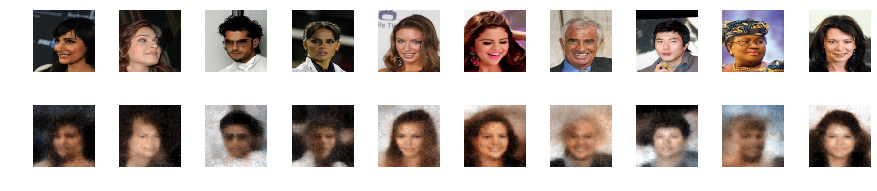

In [45]:
n_to_show = 10


from torch.utils.data import WeightedRandomSampler,DataLoader

dataloader = DataLoader(dataset=test_dataset,
                    batch_size=32,  # 组织成batch大小
                    sampler=WeightedRandomSampler(torch.ones(len(test_dataset)), 32))

example_batch=next(iter(dataloader))
example_images = example_batch.to(device)
net.eval()
reconst_images,mu,log_var=net(example_images)


fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+1)
    sub.axis('off')        
    sub.imshow(img.cpu().numpy().transpose((1,2,0)))

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    sub.axis('off')
    sub.imshow(img.detach().cpu().numpy().transpose((1,2,0)))
fig.savefig('2.png')

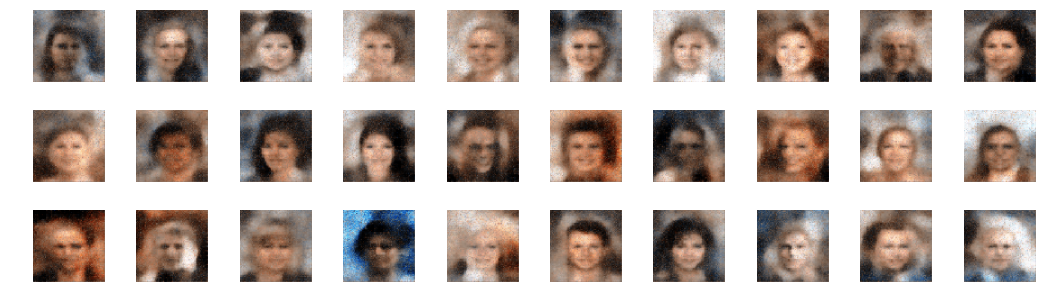

In [31]:
n_to_show = 30

znew = np.random.normal(size = (n_to_show,net.z_dim))

reconst = predict(net,torch.randn_like(mu))

fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(n_to_show):
    img = reconst[i].squeeze()
    ax = fig.add_subplot(3, 10, i+1)
    ax.imshow(img.detach().cpu().numpy().transpose((1,2,0)))
    ax.axis('off')

plt.show()
fig.savefig('1.png')

## celeba数据集上训练VAE（tensorflow）

In [31]:
from keras.callbacks import Callback, LearningRateScheduler
import numpy as np
import matplotlib.pyplot as plt
import os

#### CALLBACKS
class CustomCallback(Callback):
    
    def __init__(self, run_folder, print_every_n_batches, initial_epoch, vae):
        self.epoch = initial_epoch
        self.run_folder = run_folder
        self.print_every_n_batches = print_every_n_batches
        self.vae = vae

    def on_batch_end(self, batch, logs={}):  
        if batch % self.print_every_n_batches == 0:
            z_new = np.random.normal(size = (1,self.vae.z_dim))
            reconst = self.vae.decoder.predict(np.array(z_new))[0].squeeze()

            filepath = os.path.join(self.run_folder, 'images', 'img_' + str(self.epoch).zfill(3) + '_' + str(batch) + '.jpg')
            if len(reconst.shape) == 2:
                plt.imsave(filepath, reconst, cmap='gray_r')
            else:
                plt.imsave(filepath, reconst)

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch += 1



def step_decay_schedule(initial_lr, decay_factor=0.5, step_size=1):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''
    def schedule(epoch):
        new_lr = initial_lr * (decay_factor ** np.floor(epoch/step_size))
        
        return new_lr

    return LearningRateScheduler(schedule)

Using TensorFlow backend.


In [32]:

from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint 
from keras.utils import plot_model



import numpy as np
import json
import os
import pickle


class VariationalAutoencoder():
    def __init__(self
        , input_dim
        , encoder_conv_filters
        , encoder_conv_kernel_size
        , encoder_conv_strides
        , decoder_conv_t_filters
        , decoder_conv_t_kernel_size
        , decoder_conv_t_strides
        , z_dim
        , use_batch_norm = False
        , use_dropout= False
        ):

        self.name = 'variational_autoencoder'

        self.input_dim = input_dim
        self.encoder_conv_filters = encoder_conv_filters
        self.encoder_conv_kernel_size = encoder_conv_kernel_size
        self.encoder_conv_strides = encoder_conv_strides
        self.decoder_conv_t_filters = decoder_conv_t_filters
        self.decoder_conv_t_kernel_size = decoder_conv_t_kernel_size
        self.decoder_conv_t_strides = decoder_conv_t_strides
        self.z_dim = z_dim

        self.use_batch_norm = use_batch_norm
        self.use_dropout = use_dropout

        self.n_layers_encoder = len(encoder_conv_filters)
        self.n_layers_decoder = len(decoder_conv_t_filters)

        self._build()

    def _build(self):
        
        ### THE ENCODER
        encoder_input = Input(shape=self.input_dim, name='encoder_input')

        x = encoder_input

        for i in range(self.n_layers_encoder):
            conv_layer = Conv2D(
                filters = self.encoder_conv_filters[i]
                , kernel_size = self.encoder_conv_kernel_size[i]
                , strides = self.encoder_conv_strides[i]
                , padding = 'same'
                , name = 'encoder_conv_' + str(i)
                )

            x = conv_layer(x)

            if self.use_batch_norm:
                x = BatchNormalization()(x)

            x = LeakyReLU()(x)

            if self.use_dropout:
                x = Dropout(rate = 0.25)(x)

        shape_before_flattening = K.int_shape(x)[1:]

        x = Flatten()(x)
        self.mu = Dense(self.z_dim, name='mu')(x)
        self.log_var = Dense(self.z_dim, name='log_var')(x)

        self.encoder_mu_log_var = Model(encoder_input, (self.mu, self.log_var))

        def sampling(args):
            mu, log_var = args
            epsilon = K.random_normal(shape=K.shape(mu), mean=0., stddev=1.)
            return mu + K.exp(log_var / 2) * epsilon

        encoder_output = Lambda(sampling, name='encoder_output')([self.mu, self.log_var])

        self.encoder = Model(encoder_input, encoder_output)
        
        

        ### THE DECODER

        decoder_input = Input(shape=(self.z_dim,), name='decoder_input')

        x = Dense(np.prod(shape_before_flattening))(decoder_input)
        x = Reshape(shape_before_flattening)(x)

        for i in range(self.n_layers_decoder):
            conv_t_layer = Conv2DTranspose(
                filters = self.decoder_conv_t_filters[i]
                , kernel_size = self.decoder_conv_t_kernel_size[i]
                , strides = self.decoder_conv_t_strides[i]
                , padding = 'same'
                , name = 'decoder_conv_t_' + str(i)
                )

            x = conv_t_layer(x)

            if i < self.n_layers_decoder - 1:
                if self.use_batch_norm:
                    x = BatchNormalization()(x)
                x = LeakyReLU()(x)
                if self.use_dropout:
                    x = Dropout(rate = 0.25)(x)
            else:
                x = Activation('sigmoid')(x)

            

        decoder_output = x

        self.decoder = Model(decoder_input, decoder_output)

        ### THE FULL VAE
        model_input = encoder_input
        model_output = self.decoder(encoder_output)

        self.model = Model(model_input, model_output)


    def compile(self, learning_rate, r_loss_factor):
        self.learning_rate = learning_rate

        ### COMPILATION
        def vae_r_loss(y_true, y_pred):
            r_loss = K.mean(K.square(y_true - y_pred), axis = [1,2,3])
            return r_loss_factor * r_loss

        def vae_kl_loss(y_true, y_pred):
            kl_loss =  -0.5 * K.sum(1 + self.log_var - K.square(self.mu) - K.exp(self.log_var), axis = 1)
            return kl_loss

        def vae_loss(y_true, y_pred):
            r_loss = vae_r_loss(y_true, y_pred)
            kl_loss = vae_kl_loss(y_true, y_pred)
            return  r_loss + kl_loss

        optimizer = Adam(lr=learning_rate)
        self.model.compile(optimizer=optimizer, loss = vae_loss,  metrics = [vae_r_loss, vae_kl_loss])


    def save(self, folder):

        if not os.path.exists(folder):
            os.makedirs(folder)
            os.makedirs(os.path.join(folder, 'viz'))
            os.makedirs(os.path.join(folder, 'weights'))
            os.makedirs(os.path.join(folder, 'images'))

        with open(os.path.join(folder, 'params.pkl'), 'wb') as f:
            pickle.dump([
                self.input_dim
                , self.encoder_conv_filters
                , self.encoder_conv_kernel_size
                , self.encoder_conv_strides
                , self.decoder_conv_t_filters
                , self.decoder_conv_t_kernel_size
                , self.decoder_conv_t_strides
                , self.z_dim
                , self.use_batch_norm
                , self.use_dropout
                ], f)

        self.plot_model(folder)


    def load_weights(self, filepath):
        self.model.load_weights(filepath)

    def train(self, x_train, batch_size, epochs, run_folder, print_every_n_batches = 100, initial_epoch = 0, lr_decay = 1):

        custom_callback = CustomCallback(run_folder, print_every_n_batches, initial_epoch, self)
        lr_sched = step_decay_schedule(initial_lr=self.learning_rate, decay_factor=lr_decay, step_size=1)
        
        checkpoint_filepath=os.path.join(run_folder, "weights/weights-{epoch:03d}-{loss:.2f}.h5")
        checkpoint1 = ModelCheckpoint(checkpoint_filepath, save_weights_only = True, verbose=1)
        checkpoint2 = ModelCheckpoint(os.path.join(run_folder, 'weights/weights.h5'), save_weights_only = True, verbose=1)

        callbacks_list = [checkpoint1, checkpoint2, custom_callback, lr_sched]

        self.model.fit(     
            x_train
            , x_train
            , batch_size = batch_size
            , shuffle = True
            , epochs = epochs
            , initial_epoch = initial_epoch
            , callbacks = callbacks_list
        )



    def train_with_generator(self, data_flow, epochs, steps_per_epoch, run_folder, print_every_n_batches = 100, initial_epoch = 0, lr_decay = 1, ):

        custom_callback = CustomCallback(run_folder, print_every_n_batches, initial_epoch, self)
        lr_sched = step_decay_schedule(initial_lr=self.learning_rate, decay_factor=lr_decay, step_size=1)

        checkpoint_filepath=os.path.join(run_folder, "weights/weights-{epoch:03d}-{loss:.2f}.h5")
        checkpoint1 = ModelCheckpoint(checkpoint_filepath, save_weights_only = True, verbose=1)
        checkpoint2 = ModelCheckpoint(os.path.join(run_folder, 'weights/weights.h5'), save_weights_only = True, verbose=1)

        callbacks_list = [checkpoint1, checkpoint2, custom_callback, lr_sched]

        self.model.save_weights(os.path.join(run_folder, 'weights/weights.h5'))
                
        self.model.fit_generator(
            data_flow
            , shuffle = True
            , epochs = epochs
            , initial_epoch = initial_epoch
            , callbacks = callbacks_list
            , steps_per_epoch=steps_per_epoch 
            )


    
    def plot_model(self, run_folder):
        plot_model(self.model, to_file=os.path.join(run_folder ,'viz/model.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.encoder, to_file=os.path.join(run_folder ,'viz/encoder.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.decoder, to_file=os.path.join(run_folder ,'viz/decoder.png'), show_shapes = True, show_layer_names = True)



        


        

        




In [33]:
!mkdir vae

In [34]:
cd /kaggle/working/vae

/kaggle/working/vae


In [35]:
!mkdir run

In [36]:
cd run

/kaggle/working/vae/run


In [37]:
!mkdir vae

In [38]:
cd ..

/kaggle/working/vae


In [39]:
# run params
section = 'vae'
run_id = '0001'
data_name = 'faces'
RUN_FOLDER = 'run/{}/'.format(section)
RUN_FOLDER += '_'.join([run_id, data_name])

if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'build' #'load' #


DATA_FOLDER = '/kaggle/input/celebrity-face-image-dataset/Celebrity Faces Dataset'

In [40]:
import glob
INPUT_DIM = (128,128,3)
BATCH_SIZE = 32

filenames = np.array(glob.glob(os.path.join(DATA_FOLDER, '**/*.jpg')))

len(filenames)

1800

In [41]:
from keras.preprocessing.image import ImageDataGenerator
data_gen = ImageDataGenerator(rescale=1./255)

data_flow = data_gen.flow_from_directory(DATA_FOLDER
                                         , target_size = INPUT_DIM[:2]
                                         , batch_size = BATCH_SIZE
                                         , shuffle = True
                                         , class_mode = 'input'
                                         , subset = "training"
                                            )

Found 1800 images belonging to 17 classes.


In [42]:
vae = VariationalAutoencoder(
                input_dim = INPUT_DIM
                , encoder_conv_filters=[32,64,64, 64]
                , encoder_conv_kernel_size=[3,3,3,3]
                , encoder_conv_strides=[2,2,2,2]
                , decoder_conv_t_filters=[64,64,32,3]
                , decoder_conv_t_kernel_size=[3,3,3,3]
                , decoder_conv_t_strides=[2,2,2,2]
                , z_dim=200
                , use_batch_norm=True
                , use_dropout=True)

if mode == 'build':
    vae.save(RUN_FOLDER)
else:
    vae.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))

In [18]:
vae.encoder.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
encoder_conv_0 (Conv2D)         (None, 64, 64, 32)   896         encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 64, 64, 32)   128         encoder_conv_0[0][0]             
__________________________________________________________________________________________________
leaky_re_lu_9 (LeakyReLU)       (None, 64, 64, 32)   0           batch_normalization_9[0][0]      
____________________________________________________________________________________________

In [43]:
LEARNING_RATE = 0.0005
R_LOSS_FACTOR = 10000
EPOCHS = 5
PRINT_EVERY_N_BATCHES = 100
INITIAL_EPOCH = 0

In [44]:
vae.compile(LEARNING_RATE, R_LOSS_FACTOR)

In [45]:
NUM_IMAGES = len(filenames)
vae.train_with_generator(     
    data_flow
    , epochs = EPOCHS
    , steps_per_epoch = NUM_IMAGES / BATCH_SIZE
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
    , initial_epoch = INITIAL_EPOCH
)

Epoch 1/5
 6/56 [==>...........................] - ETA: 30s - loss: 1363.3516 - vae_r_loss: 1168.8824 - vae_kl_loss: 194.4691

/opt/conda/lib/python3.6/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169903). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


57/56 [==============================] - 10s 169ms/step - loss: 1013.6108 - vae_r_loss: 896.6407 - vae_kl_loss: 116.4693

Epoch 00001: saving model to run/vae/0001_faces/weights/weights-001-1013.11.h5

Epoch 00001: saving model to run/vae/0001_faces/weights/weights.h5
Epoch 2/5
57/56 [==============================] - 8s 133ms/step - loss: 585.4428 - vae_r_loss: 479.4607 - vae_kl_loss: 103.8932

Epoch 00002: saving model to run/vae/0001_faces/weights/weights-002-583.35.h5

Epoch 00002: saving model to run/vae/0001_faces/weights/weights.h5
Epoch 3/5
57/56 [==============================] - 8s 141ms/step - loss: 516.7455 - vae_r_loss: 420.4389 - vae_kl_loss: 95.7355

Epoch 00003: saving model to run/vae/0001_faces/weights/weights-003-516.17.h5

Epoch 00003: saving model to run/vae/0001_faces/weights/weights.h5
Epoch 4/5
57/56 [==============================] - 8s 141ms/step - loss: 485.7559 - vae_r_loss: 394.1655 - vae_kl_loss: 90.9824

Epoch 00004: saving model to run/vae/0001_faces/wei

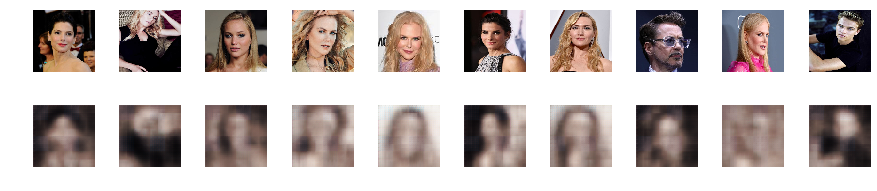

In [80]:
n_to_show = 10

#data_flow_generic = imageLoader.build(att, n_to_show)

example_batch = next(data_flow)
example_images = example_batch[0]

z_points = vae.encoder.predict(example_images)

reconst_images = vae.decoder.predict(z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+1)
    sub.axis('off')        
    sub.imshow(img)

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    sub.axis('off')
    sub.imshow(img)


In [81]:
example_images[0].mean()

0.27658558

In [83]:
reconst_images[0].mean()

0.30814746